In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchmetrics
import torchvision as tv

import lightning as L
import matplotlib.pyplot as plt
import numpy as np

# Identical code as file `lightning-ai-demo-cpu.ipynb`. The only difference is the output. I'm running this Jupyter notebook on my Macbook Pro M2 with built-in GPU. Lightning (formerly named pytorch-lightning) will detect the GPU and use it if possible.

print("Using torch", torch.__version__)
print("Using lightning", L.__version__)

Using torch 2.5.0
Using lightning 2.4.0


Number of training samples: 55000
Number of validation samples: 4000
Number of test samples: 1000
Shape of image: torch.Size([1, 28, 28])
Label for this image: 3


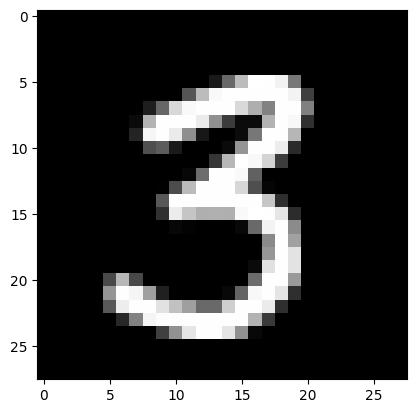

In [2]:
# --------------------
# Load Dataset - MNIST
# --------------------

# dataset: tuple[tensor of shape (N, R, C), label: int]
dataset = tv.datasets.MNIST(root=".", download=True, transform=tv.transforms.ToTensor())
train, val, test = data.random_split(dataset, [55000, 4000, 1000], torch.Generator().manual_seed(42))

# visualize
n = 44
image, label = train[n]
print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of test samples: {len(test)}")
print(f"Shape of image: {image.shape}")
print(f"Label for this image: {label}")
plt.imshow(image.squeeze(), cmap="gray")

In [3]:
from IPython.display import Image
Image(url="https://www.gabormelli.com/RKB/images/1/19/2NNw.png")

In [4]:
# ------------
# Create Model
# ------------
class HelloModel(L.LightningModule):
    def __init__(self, hidden_nodes: int = 64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=hidden_nodes),
            nn.ReLU(),
            nn.Linear(in_features=hidden_nodes, out_features=10),
        )
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.encoder(x)

    def training_step(self, batch):
        loss = self._step(batch, "train")
        return loss

    def validation_step(self, batch):
        loss = self._step(batch, "val")
        return loss

    def _step(self, batch, step_type):
        images, labels = batch  # images: NxRxC
        n_batch = len(images)
        images = images.view(n_batch, -1)  # images: N x (RxC)
        
        # make predictions
        predictions = self.encoder(images)
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(predictions, labels)
        self.log(f"{step_type}_loss", loss)
        
        if step_type == "train":
            self.train_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.train_accuracy)
        else:
            self.val_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.val_accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [5]:
# -----------
# Train Model
# -----------
model = HelloModel(hidden_nodes=64)

train_dataloader = data.DataLoader(
    dataset=train,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
val_dataloader = data.DataLoader(
    dataset=val,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
trainer = L.Trainer(max_epochs=5)
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/merrillmck/source/github/lightning-ai-demonstration/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | Sequential         | 50.9 K | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
----------------

Epoch 0: 100%|██████████| 1719/1719 [00:10<00:00, 166.04it/s, v_num=1]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 1719/1719 [00:08<00:00, 210.86it/s, v_num=1]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 1719/1719 [00:08<00:00, 209.34it/s, v_num=1]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 1719/1719 [00:08<00:00, 212.85it/s, v_num=1]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1719/1719 [00:08<00:00, 213.62it/s, v_num=1]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 1719/1719 [00:08<00:00, 207.00it/s, v_num=1]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1719/1719 [00:08<00:00, 206.86it/s, v_num=1]


6
tensor([[ -1.8606,  -7.2006,   0.0226,  -3.3801,  -5.0046,  -1.6038,  11.3967,
         -13.9377,  -2.9211, -10.9251]], grad_fn=<AddmmBackward0>)


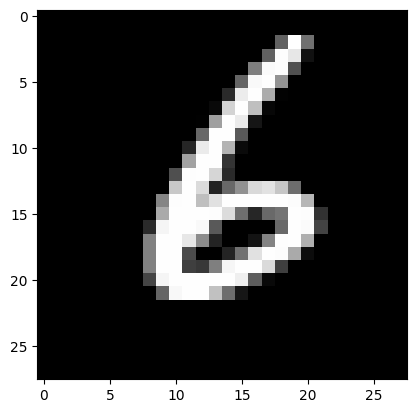

In [6]:
# -------------
# Run Inference
# -------------
n = 53
image, label = test[n]
plt.imshow(image.squeeze(), cmap="gray")
image = image.view(1, -1)
pred = model.encoder(image)
print(label)
print(pred)

In [ ]:
# tensorboard --logdir .